<a href="https://colab.research.google.com/github/hoyeonj981/MyColab/blob/main/MMC_MC_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update -qq
!pip install --quiet pandas numpy matplotlib

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

### [수집 데이터 Sheet ](https://docs.google.com/spreadsheets/d/1jjpcpmsi0MSbGH3qUmbc_LHutG-nZ6EXMVaUGpscMhE/edit?usp=sharing)

In [3]:
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQ1eVWTm9TWsfTvFHiiGpelyebYDElKjOifrrrGpLa7hK6ltOOD8DAro1OS7PPS5xexT9_uSW8uJADp/pub?output=csv"
df = pd.read_csv(url)

## 1. 수집한 데이터 히스토그램

- 평균 132초
- 중간값 116초

###### 참고

- 수집한 데이터는 수기로 입력하기 때문에 실제 데이터와 차이가 있을 수 있음
- 예) 터치 불량, 개인 실수 등

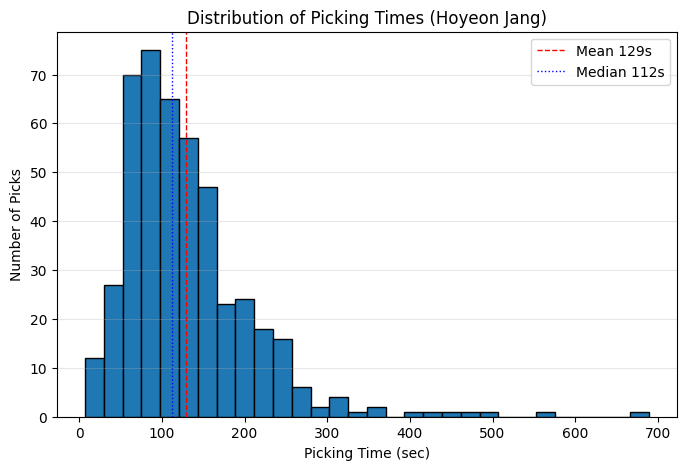

In [4]:
plt.figure(figsize=(8, 5))
plt.hist(df['DurationSec'], bins=30, edgecolor='black')
plt.xlabel('Picking Time (sec)')
plt.ylabel('Number of Picks')
plt.title('Distribution of Picking Times (Hoyeon Jang)')

mean_val   = df['DurationSec'].mean()
median_val = df['DurationSec'].median()
plt.axvline(mean_val,   color='red',  linestyle='--', linewidth=1,
            label=f'Mean {mean_val:.0f}s')
plt.axvline(median_val, color='blue', linestyle=':',  linewidth=1,
            label=f'Median {median_val:.0f}s')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()


## 2. 전체 주문에 대한 누적 막대 그래프
- 80%가 정상 처리
- 20%가 지연 사유 (고중량, 재고 없음, 전산 불일치, 먼거리 이동)

### 2.1 지연 시간 중 상위 5%에 해당하는 지연 사유

- 260초 이상 지연이 발생하는 5% 그룹
- 그 중에서 약 44%가 '재고 없음'

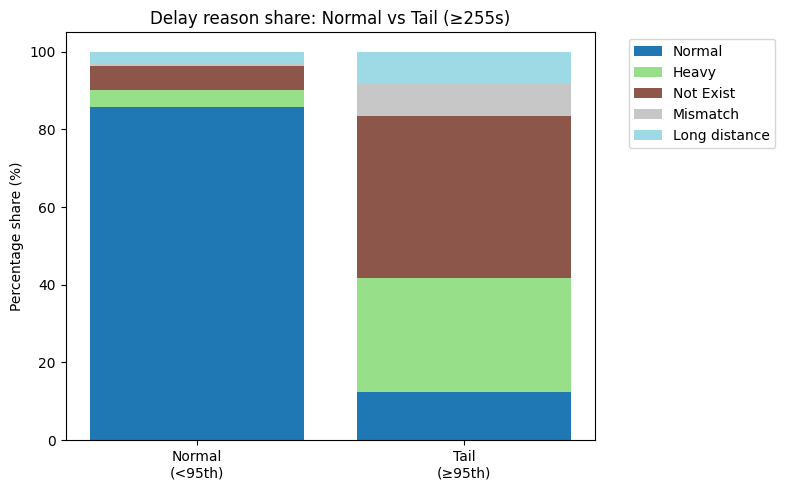

In [5]:
DUR_COL = 'DurationSec'
REASON_COL = 'Result'

reason_map = {
    0: 'Normal',                # 정상 처리
    1: 'Heavy',                 # 고중량
    2: 'Not Exist',             # 재고 없음
    3: 'Mismatch',              # 전산 불일치
    4: 'Long distance'          # 먼거리 이동
}

# 장시간 임계값
tail_thr = np.percentile(df[DUR_COL], 95)   # 95

def share_by_reason(sub):
    c = sub[REASON_COL].value_counts(normalize=True) * 100
    return c

share_normal = share_by_reason(df[df[DUR_COL] <  tail_thr])
share_tail   = share_by_reason(df[df[DUR_COL] >= tail_thr])


all_reasons = share_normal.index.union(share_tail.index)
share_normal = share_normal.reindex(all_reasons, fill_value=0)
share_tail   = share_tail.reindex(all_reasons, fill_value=0)

fig, ax = plt.subplots(figsize=(8,5))
bottom = np.zeros(2)
colors = plt.cm.tab20(np.linspace(0, 1, len(all_reasons)))

for reason, color in zip(all_reasons, colors):
    vals  = [share_normal[reason], share_tail[reason]]
    label = reason_map.get(reason, str(reason))
    ax.bar(['Normal\n(<95th)', 'Tail\n(≥95th)'],
           vals, bottom=bottom, label=label, color=color)
    bottom += vals

ax.set_ylabel('Percentage share (%)')
ax.set_title(f'Delay reason share: Normal vs Tail (≥{tail_thr:.0f}s)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 3. 시뮬레이션 모델

- M/M/c + Monte Carlo

In [6]:
"""
M/M/c 시뮬레이터에 동적 피커 수 조정, 포장시간, 재고존 지연을 추가.
    - n_orders : 샘플링할 주문 수
    - lam: 주문 도착률(orders/min)
    - service_sampler: 서비스시간 생성 함수
    - c_min: 기본 피커 수 (5명)
    - c_max: 최대 피커 수 (8명)
    - queue_threshold: 대기 주문 수가 이 값보다 크면 피커를 늘림
    - wait_threshold: 최근 평균 대기시간(초)이 이 값보다 크면 피커를 늘림
    - improve: 개선 효과. 0.6이면 40% 단축.
    - sla_sec: SLA 기준. default 600초(10분)
"""
def simulate_mmc_dynamic(n_orders,
                         lam,
                         service_sampler,
                         c_min=5, c_max=8,
                         queue_threshold=13,
                         wait_threshold=600,
                         improve=1.0,
                         sla_sec=600,
                         seed=0):
    rng = np.random.default_rng(seed)
    arrival_gaps = rng.exponential(scale=60/lam, size=n_orders)
    arrivals = np.cumsum(arrival_gaps)

    # 최대 피커 수 만큼의 '다음 가능 시각' 배열을 만들고 기본 c_min명만 사용
    free = np.zeros(c_max)
    waits, totals = [], []
    active = c_min

    for i, t in enumerate(arrivals):
        # 현재 시점 t에 busy한 피커 수 계산
        busy_count = np.sum(free[:active] > t)
        # 최근 50건의 대기시간 평균으로 현황 파악
        recent_wait = np.mean(waits[-50:]) if waits else 0

        # 조건에 따라 피커 수 조정
        if busy_count > queue_threshold or recent_wait > wait_threshold:
            active = c_max
        else:
            active = c_min

        # 가장 빨리 비는 피커를 선택
        idx = np.argmin(free[:active])
        start = max(t, free[idx])
        waits.append(start - t)

        s = service_sampler(rng) * improve
        finish = start + s
        totals.append(finish - t)
        free[idx] = finish

    df_sim = pd.DataFrame({'wait': waits, 'total': totals})
    df_sim['sla'] = df_sim['total'] > sla_sec
    return df_sim

In [7]:
df = df.dropna(subset=['startTime','DurationSec']).copy()
df['Result'] = df['Result'].fillna(0).astype(int)

# 정상 주문과 문제 주문(고중량·재고없음·전산불일치·먼거리 등) 분리
service_times_normal = df[df['Result']==0]['DurationSec'].astype(float).values
service_times_issue  = df[df['Result']!=0]['DurationSec'].astype(float).values
p_issue = len(service_times_issue) / len(df)

# 포장시간: 120~180초를 균등분포로 모델링
def packaging_sampler(rng):
    return rng.uniform(120, 180)

# 수집 데이터와 문제 주문 발생 비율을 반영한 서비스시간 샘플러.
def service_sampler_mixed(rng):
    # 기본 피킹시간은 정상 주문 분포에서 샘플
    base_time = rng.choice(service_times_normal)
    if rng.random() < p_issue:
        # 문제 주문: 문제 주문 분포에서 하나 샘플링하여
        # 정상 주문 평균보다 얼마나 더 걸리는지 계산한 뒤 추가
        extra = rng.choice(service_times_issue) - service_times_normal.mean()
        base_time += max(0, extra)
    return base_time + packaging_sampler(rng)

In [8]:
def kpi(df):
    return {
        "Mean(s)"   : df["total"].mean(),
        "P95(s)"    : np.percentile(df["total"], 95),
        "SLA > 10m %" : df["sla"].mean() * 100,
        "AvgWait(s)": df["wait"].mean()
    }

In [12]:
# 파라미터 설정
orders = 10000
lam_peak = 130/60

# 기존 시스템
base_df_dynamic = simulate_mmc_dynamic(
    n_orders=orders,
    lam=lam_peak,
    service_sampler=service_sampler_mixed,
    c_min=5,
    c_max=8,
    queue_threshold=13,
    wait_threshold=600,
    improve=1.0,
    sla_sec=600,
    seed=1
)

# 개선안: 재고존에 바코드 등 인덱스 부여해 탐색시간 단축 → 서비스시간 40% 단축
after_df_dynamic = simulate_mmc_dynamic(
    n_orders=orders,
    lam=lam_peak,
    service_sampler=service_sampler_mixed,
    c_min=5,
    c_max=8,
    queue_threshold=13,
    wait_threshold=600,
    improve=0.6,  # 서비스시간을 40% 줄임
    sla_sec=600,
    seed=1
)

# KPI 비교
base_kpi  = kpi(base_df_dynamic)
after_kpi = kpi(after_df_dynamic)
kpis = pd.DataFrame({'Baseline': base_kpi, 'After': after_kpi}).T.round(2)
display(kpis)

,Mean(s),P95(s),SLA > 10m %,AvgWait(s)
Baseline,37869.54,71088.07,99.80,37588.59
After,746.21,1071.82,78.59,577.63
